Алгоритм действий.
1. Делаем рескейлинг изображения (надо чтобы параметры предобработки были универсальны для всех изображений)
2. Проводим предобработку (чб, шум, трешолд и тп)
3. Сохраняем полученное чб изображение
4. Поправляем его угол (код утащила, ссылка там дальше есть. Если кратко - он выделяет на изображении контуры, оставляет только "прямоугольные" и потом по самому большому контуру вычисляет угол и поворачивает)

In [158]:
#imports

import cv2
from img2table.document import Image as Im
import math
from matplotlib import pyplot as plt
import numpy as np

#import pytesseract
#from PIL import Image as PILImage
#from IPython.display import display_html
#from PIL import Image as pilimage
#from img2table.ocr import TesseractOCR

#pytesseract.pytesseract.tesseract_cmd ='C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

IMAGE_WIDTH = 2000

## Image preprocessing

Чтение изображения

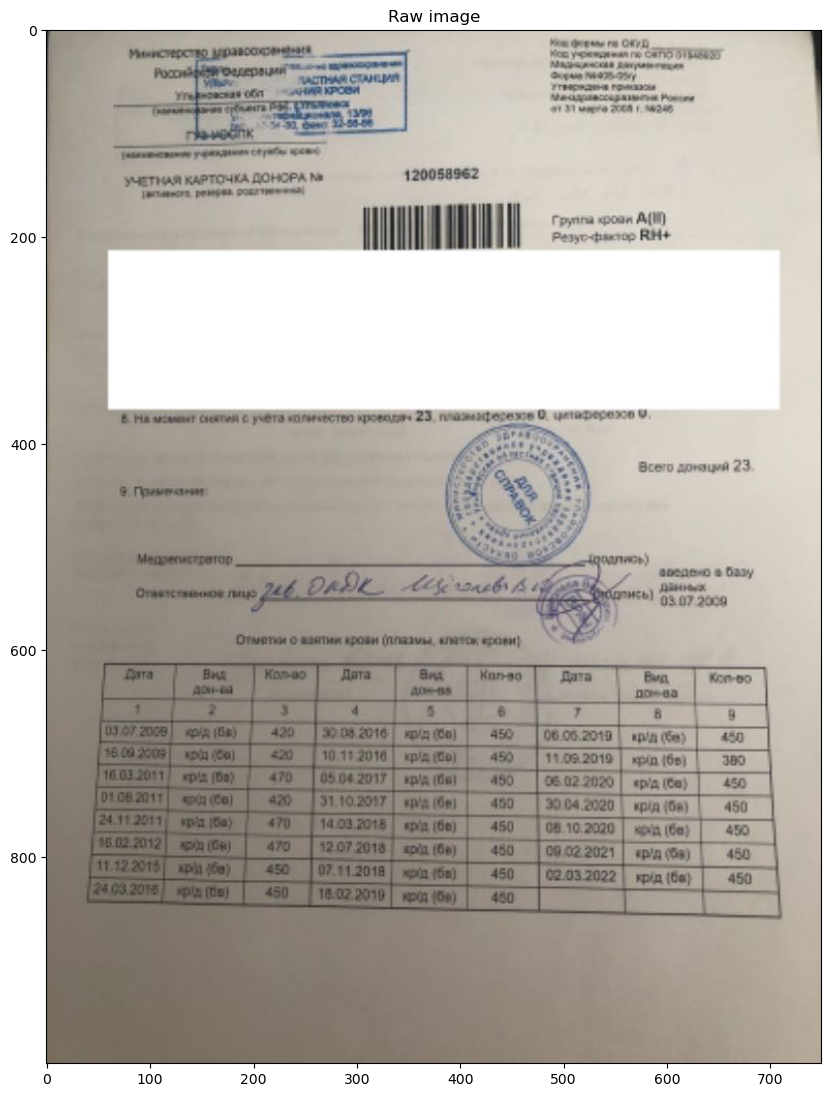

In [159]:
#path for picture
src = 'results\\228963.jpg'

image = cv2.imread(src)
image = np.ascontiguousarray(image[..., [2, 1, 0]])
plt.figure(figsize=(10,15))
plt.imshow(image)
plt.title('Raw image')
plt.show()

Изменение размера изображения, так чтобы по ширине картинка стала  = IMAGE_WIDTH

In [160]:
def rescale(image):
    h, w, c = image.shape
    ratio = h / w
    # Set new size
    width = IMAGE_WIDTH
    height = int(ratio * width)
    points = (width, height)
    # resize the image
    return cv2.resize(image, points, interpolation = cv2.INTER_LINEAR)

функция предобработки картинки

In [161]:
def preprocess_img(path,
                   dn_h=3,  dn_templateWindowSize=7, dn_searchWindowSize=21,
                   blur_ksize=3,
                   thr_BlockSize=11,thr_c=2,
                   visualize=False):
    
    #load image
    image = cv2.imread(path)
    image = np.ascontiguousarray(image[..., [2, 1, 0]])
    
    #rescale image
    image = rescale(image)
    
    # denoising of image
        #h: Smaller h values preserve picture details while preserving some noise,
            #while larger h values perfectly remove noise while also removing image details.
        #templateWindowSize: The template patch's size in pixels when computing weights (odd integer).
        #searchWindowSize: The window's size in pixels is what is utilized
            #to calculate the weighted average for a specific pixel (odd integer). 
        
    img_dn = cv2.fastNlMeansDenoising(image, None, dn_h, dn_templateWindowSize, dn_searchWindowSize) 
    
    #grayscale
    img_gs = cv2.cvtColor(img_dn, cv2.COLOR_BGR2GRAY)

    # Blurring
    #img_mb = cv2.medianBlur(img_gs, blur_ksize)
    img_mb = cv2.bilateralFilter(img_gs, 5, 5, 5)
    
    # thresholding
        #BlockSize - It decides the size of neighbourhood area.
        #C - It is just a constant which is subtracted from the mean or weighted mean calculated.
        
    img_thr = cv2.adaptiveThreshold(img_mb, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,thr_BlockSize,thr_c)
    
    #visualization
    if visualize:
        plt.figure(figsize=(10,13))
        plt.imshow(img_thr, 'gray')
        plt.axis('off')
        plt.title('preprocessed image')
        plt.show()
        '''
        #show steps
        plt.figure(figsize=(20,20))
        plt.subplot(131)
        plt.imshow(img_dn, 'gray')
        plt.axis('off')
        plt.title('No-noise image')
        plt.subplot(132)
        plt.imshow(img_gs, 'gray')
        plt.axis('off')
        plt.title('Gray image')
        plt.subplot(133)
        plt.imshow(img_mb, 'gray')
        plt.title('median blur')
        plt.show()
        '''
    return img_thr

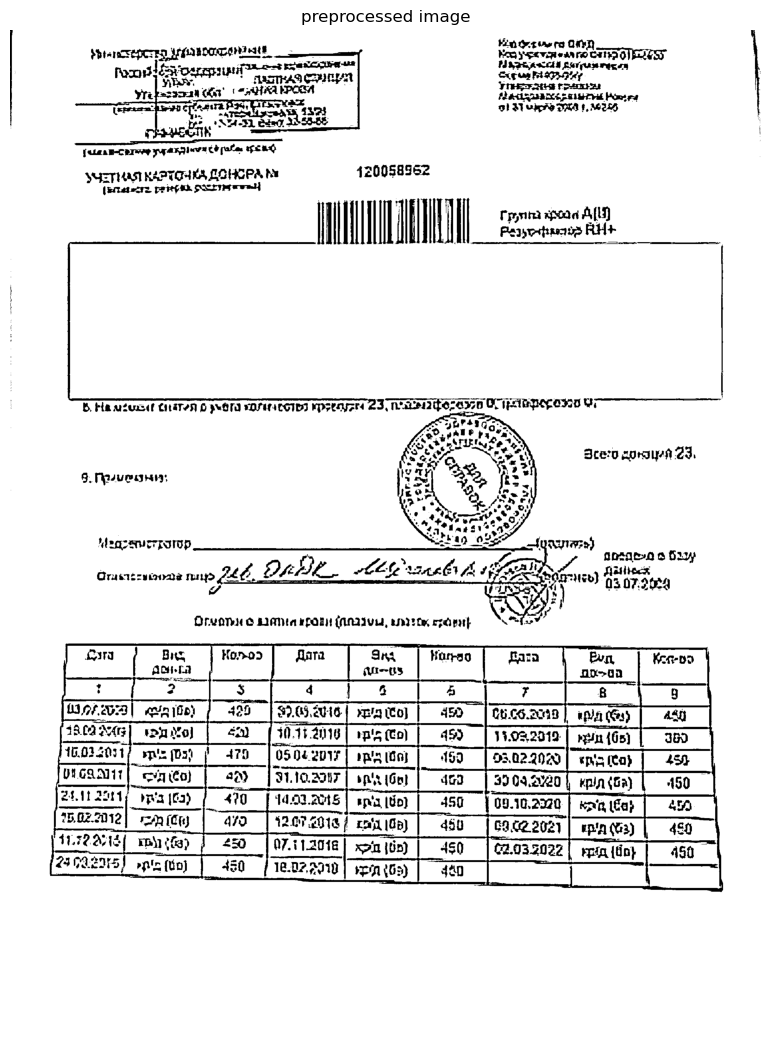

In [162]:
preprocessed_image = preprocess_img(src, visualize=True)

сохранить предобраобтанную картинку

In [163]:
src_preprocessed = src[:-4] + '_preprocessed.jpg'
cv2.imwrite(src_new,  preprocess_img(src))

True

## deskew and rotate image

copypast from https://github.com/livefiredev/ocr-extract-table-from-image-python/blob/main/main.py

Класс TableExtractor берет картинку, предобрабатывает ее, ищет контуры, отсеивает только прямоугольные и потом берет самый большой контур и по нему выправляет угол и перспективу.
С нашими сканами этот алгоритм порой лажает. Проблемы:
1. В нем плохая предобработка изображения. Поэтому я и добавила сверху свой вариант, после которого все работает стабильнее
2. Иногда самым большим прямоугольником оказывается тот, которым замазали персональные данные. И вот эту проблему я пока не решила. Возможно, решается дерганьем параметров при той же предобработке (например, на стадии трешолдинга. Потому что белый прямоугольник по тону все-таки близок к фону, может его удастся "слить" с фоном)

In [164]:
class TableExtractor:
    def __init__(self, image_path):
        self.image_path = image_path

    def execute(self):
        self.read_image()
        self.store_process_image("0_original.jpg", self.image)
        self.convert_image_to_grayscale()
        self.store_process_image("1_grayscaled.jpg", self.grayscale_image)
        self.threshold_image()
        self.store_process_image("3_thresholded.jpg", self.thresholded_image)
        self.invert_image()
        self.store_process_image("4_inverteded.jpg", self.inverted_image)
        self.dilate_image()
        self.store_process_image("5_dialateded.jpg", self.dilated_image)
        self.find_contours()
        self.store_process_image("6_all_contours.jpg", self.image_with_all_contours)
        self.filter_contours_and_leave_only_rectangles()
        self.store_process_image("7_only_rectangular_contours.jpg", self.image_with_only_rectangular_contours)
        self.find_largest_contour_by_area()
        self.store_process_image("8_contour_with_max_area.jpg", self.image_with_contour_with_max_area)
        self.order_points_in_the_contour_with_max_area()
        self.store_process_image("9_with_4_corner_points_plotted.jpg", self.image_with_points_plotted)
        self.calculate_new_width_and_height_of_image()
        self.apply_perspective_transform()
        self.store_process_image("10_perspective_corrected.jpg", self.perspective_corrected_image)
        self.add_10_percent_padding()
        self.store_process_image("11_perspective_corrected_with_padding.jpg", self.perspective_corrected_image_with_padding)
        return self.perspective_corrected_image_with_padding

    def read_image(self):
        self.image = cv2.imread(self.image_path)

    def convert_image_to_grayscale(self):
        self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def blur_image(self):
        self.blurred_image = cv2.blur(self.grayscale_image, (5, 5))

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def dilate_image(self):
        self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=5)
        return self.dilated_image

    def find_contours(self):
        self.contours, self.hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.image_with_all_contours = self.image.copy()
        cv2.drawContours(self.image_with_all_contours, self.contours, -1, (0, 255, 0), 3)

    def filter_contours_and_leave_only_rectangles(self):
        self.rectangular_contours = []
        for contour in self.contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:
                self.rectangular_contours.append(approx)
        self.image_with_only_rectangular_contours = self.image.copy()
        cv2.drawContours(self.image_with_only_rectangular_contours, self.rectangular_contours, -1, (0, 255, 0), 3)

    def find_largest_contour_by_area(self):
        max_area = 0
        self.contour_with_max_area = None
        for contour in self.rectangular_contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                self.contour_with_max_area = contour
        self.image_with_contour_with_max_area = self.image.copy()
        cv2.drawContours(self.image_with_contour_with_max_area, [self.contour_with_max_area], -1, (0, 255, 0), 3)

    def order_points_in_the_contour_with_max_area(self):
        self.contour_with_max_area_ordered = self.order_points(self.contour_with_max_area)
        self.image_with_points_plotted = self.image.copy()
        for point in self.contour_with_max_area_ordered:
            point_coordinates = (int(point[0]), int(point[1]))
            self.image_with_points_plotted = cv2.circle(self.image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)

    def calculate_new_width_and_height_of_image(self):
        existing_image_width = self.image.shape[1]
        existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)
        
        distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[1])
        distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[3])

        aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right

        self.new_image_width = existing_image_width_reduced_by_10_percent
        self.new_image_height = int(self.new_image_width * aspect_ratio)

    def apply_perspective_transform(self):
        pts1 = np.float32(self.contour_with_max_area_ordered)
        pts2 = np.float32([[0, 0], [self.new_image_width, 0], [self.new_image_width, self.new_image_height], [0, self.new_image_height]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        self.perspective_corrected_image = cv2.warpPerspective(self.image, matrix, (self.new_image_width, self.new_image_height))

    def add_10_percent_padding(self):
        image_height = self.image.shape[0]
        padding = int(image_height * 0.1)
        self.perspective_corrected_image_with_padding = cv2.copyMakeBorder(self.perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    def draw_contours(self):
        self.image_with_contours = self.image.copy()
        cv2.drawContours(self.image_with_contours,  [ self.contour_with_max_area ], -1, (0, 255, 0), 1)

    def calculateDistanceBetween2Points(self, p1, p2):
        dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
        return dis
    
    def order_points(self, pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # return the ordered coordinates
        return rect
    
    def store_process_image(self, file_name, image):
        path = "./process_images/table_extractor/" + file_name
        cv2.imwrite(path, image)
        

Выделение контуров и поворот/коррекция изображения

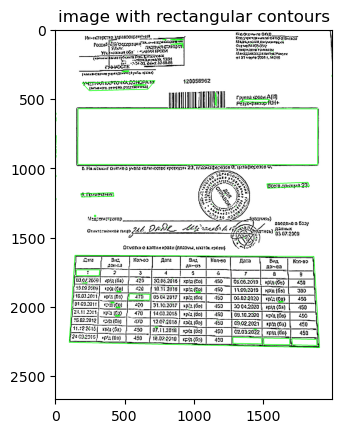

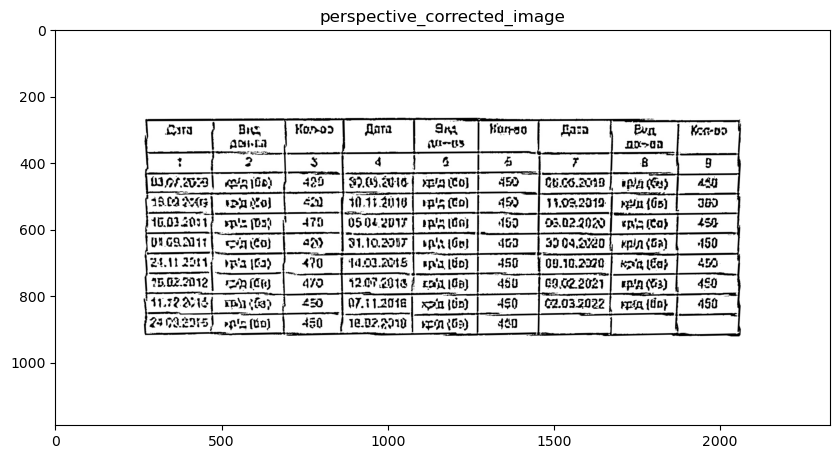

In [165]:
path_to_image = src_preprocessed

table_extractor = TableExtractor(path_to_image)
perspective_corrected_image = table_extractor.execute()
plt.imshow(table_extractor.image_with_only_rectangular_contours)
plt.title("image with rectangular contours")
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(perspective_corrected_image)
plt.title("perspective_corrected_image")
plt.show()

Дополнительно: удаление контуров таблицы.

In [166]:
class TableLinesRemover:
    def __init__(self, image):
        self.image = image

    def execute(self):
        self.grayscale_image()
        self.store_process_image("0_grayscaled.jpg", self.grey)
        self.threshold_image()
        self.store_process_image("1_thresholded.jpg", self.thresholded_image)
        self.invert_image()
        self.store_process_image("2_inverted.jpg", self.inverted_image)
        self.erode_vertical_lines()
        self.store_process_image("3_erode_vertical_lines.jpg", self.vertical_lines_eroded_image)
        self.erode_horizontal_lines()
        self.store_process_image("4_erode_horizontal_lines.jpg", self.horizontal_lines_eroded_image)
        self.combine_eroded_images()
        self.store_process_image("5_combined_eroded_images.jpg", self.combined_image)
        self.dilate_combined_image_to_make_lines_thicker()
        self.store_process_image("6_dilated_combined_image.jpg", self.combined_image_dilated)
        self.subtract_combined_and_dilated_image_from_original_image()
        self.store_process_image("7_image_without_lines.jpg", self.image_without_lines)
        self.remove_noise_with_erode_and_dilate()
        self.store_process_image("8_image_without_lines_noise_removed.jpg", self.image_without_lines_noise_removed)
        return self.image_without_lines_noise_removed

    def grayscale_image(self):
        self.grey = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grey, 127, 255, cv2.THRESH_BINARY)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def erode_vertical_lines(self):
        hor = np.array([[1,1,1,1,1,1]])
        self.vertical_lines_eroded_image = cv2.erode(self.inverted_image, hor, iterations=10)
        self.vertical_lines_eroded_image = cv2.dilate(self.vertical_lines_eroded_image, hor, iterations=10)

    def erode_horizontal_lines(self):
        ver = np.array([[1],
               [1],
               [1],
               [1],
               [1],
               [1],
               [1]])
        self.horizontal_lines_eroded_image = cv2.erode(self.inverted_image, ver, iterations=10)
        self.horizontal_lines_eroded_image = cv2.dilate(self.horizontal_lines_eroded_image, ver, iterations=10)

    def combine_eroded_images(self):
        self.combined_image = cv2.add(self.vertical_lines_eroded_image, self.horizontal_lines_eroded_image)

    def dilate_combined_image_to_make_lines_thicker(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        self.combined_image_dilated = cv2.dilate(self.combined_image, kernel, iterations=5)

    def subtract_combined_and_dilated_image_from_original_image(self):
        self.image_without_lines = cv2.subtract(self.inverted_image, self.combined_image_dilated)

    def remove_noise_with_erode_and_dilate(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        self.image_without_lines_noise_removed = cv2.erode(self.image_without_lines, kernel, iterations=1)
        self.image_without_lines_noise_removed = cv2.dilate(self.image_without_lines_noise_removed, kernel, iterations=1)

    def store_process_image(self, file_name, image):
        path = "./process_images/table_lines_remover/" + file_name
        cv2.imwrite(path, image)

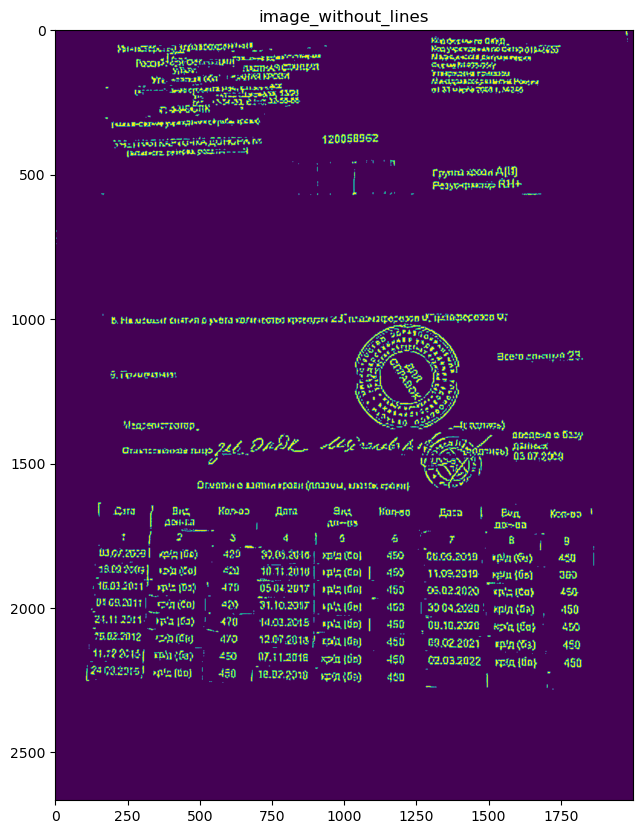

'\nocr_tool = ottt.OcrToTableTool(image_without_lines, perspective_corrected_image)\n'

In [156]:
perspective_corrected_image = table_extractor.image_with_only_rectangular_contours

lines_remover = TableLinesRemover(perspective_corrected_image)
image_without_lines = lines_remover.execute()
plt.figure(figsize=(10,10))
plt.imshow(lines_remover.image_without_lines_noise_removed)
plt.title("image_without_lines")
plt.show()

'''
ocr_tool = ottt.OcrToTableTool(image_without_lines, perspective_corrected_image)
'''

Этот класс я сама переписала на основе авторского. В нем откорректирована предобраотка и вставлен рейскейл изображения. На случай, если захочется избежать первой части всей этой работы с отдельной предообработкой и сделав ее внутри уже этого класса.

In [167]:
IMAGE_WIDTH = 2000
class TableExtractor_zhva:
    def __init__(self, image_path):
        self.image_path = image_path

    def execute(self):
        self.read_image()
        self.store_process_image("0_original.jpg", self.image)
        self.rescale_image()
        self.store_process_image("0a_rescaled.jpg", self.rescaled_image)
        self.convert_image_to_grayscale()
        self.store_process_image("1_grayscaled.jpg", self.grayscale_image)
        self.threshold_image()
        self.store_process_image("3_thresholded.jpg", self.thresholded_image)
        self.invert_image()
        self.store_process_image("4_inverteded.jpg", self.inverted_image)
        self.dilate_image()
        self.store_process_image("5_dialateded.jpg", self.dilated_image)
        self.find_contours()
        self.store_process_image("6_all_contours.jpg", self.image_with_all_contours)
        self.filter_contours_and_leave_only_rectangles()
        self.store_process_image("7_only_rectangular_contours.jpg", self.image_with_only_rectangular_contours)
        self.find_largest_contour_by_area()
        self.store_process_image("8_contour_with_max_area.jpg", self.image_with_contour_with_max_area)
        self.order_points_in_the_contour_with_max_area()
        self.store_process_image("9_with_4_corner_points_plotted.jpg", self.image_with_points_plotted)
        self.calculate_new_width_and_height_of_image()
        self.apply_perspective_transform()
        self.store_process_image("10_perspective_corrected.jpg", self.perspective_corrected_image)
        self.add_10_percent_padding()
        self.store_process_image("11_perspective_corrected_with_padding.jpg", self.perspective_corrected_image_with_padding)
        return self.perspective_corrected_image_with_padding

    def read_image(self):
        self.image = cv2.imread(self.image_path)
        
    def rescale_image(self):
        h, w, c = self.image.shape
        ratio = h / w
        # Set new size
        width = IMAGE_WIDTH
        height = int(ratio * width)
        points = (width, height)
        # resize the image
        self.rescaled_image = cv2.resize(self.image, points, interpolation = cv2.INTER_LINEAR)

    def convert_image_to_grayscale(self):
        self.grayscale_image = cv2.cvtColor(self.rescaled_image, cv2.COLOR_BGR2GRAY)

    def blur_image(self):
        self.blurred_image = cv2.bilateralFilter(self.grayscale_image, (5, 5))

    def threshold_image(self):
        #BlockSize - It decides the size of neighbourhood area.
        #C - It is just a constant which is subtracted from the mean or weighted mean calculated. 
        self.thresholded_image = cv2.adaptiveThreshold(self.grayscale_image, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,
                                                       blockSize=11, C=2)

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def dilate_image(self):
        self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=5)
        return self.dilated_image

    def find_contours(self):
        self.contours, self.hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.image_with_all_contours = self.rescaled_image.copy()
        cv2.drawContours(self.image_with_all_contours, self.contours, -1, (0, 255, 0), 3)

    def filter_contours_and_leave_only_rectangles(self):
        self.rectangular_contours = []
        for contour in self.contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:
                self.rectangular_contours.append(approx)
        self.image_with_only_rectangular_contours = self.rescaled_image.copy()
        cv2.drawContours(self.image_with_only_rectangular_contours, self.rectangular_contours, -1, (0, 255, 0), 3)

    def find_largest_contour_by_area(self):
        max_area = 0
        self.contour_with_max_area = None
        for contour in self.rectangular_contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                self.contour_with_max_area = contour
        self.image_with_contour_with_max_area = self.rescaled_image.copy()
        cv2.drawContours(self.image_with_contour_with_max_area, [self.contour_with_max_area], -1, (0, 255, 0), 3)

    def order_points_in_the_contour_with_max_area(self):
        self.contour_with_max_area_ordered = self.order_points(self.contour_with_max_area)
        self.image_with_points_plotted = self.rescaled_image.copy()
        for point in self.contour_with_max_area_ordered:
            point_coordinates = (int(point[0]), int(point[1]))
            self.image_with_points_plotted = cv2.circle(self.image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)

    def calculate_new_width_and_height_of_image(self):
        existing_image_width = self.rescaled_image.shape[1]
        existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)
        
        distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[1])
        distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[3])

        aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right

        self.new_image_width = existing_image_width_reduced_by_10_percent
        self.new_image_height = int(self.new_image_width * aspect_ratio)

    def apply_perspective_transform(self):
        pts1 = np.float32(self.contour_with_max_area_ordered)
        pts2 = np.float32([[0, 0], [self.new_image_width, 0], [self.new_image_width, self.new_image_height], [0, self.new_image_height]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        self.perspective_corrected_image = cv2.warpPerspective(self.rescaled_image, matrix, (self.new_image_width, self.new_image_height))

    def add_10_percent_padding(self):
        image_height = self.rescaled_image.shape[0]
        padding = int(image_height * 0.1)
        self.perspective_corrected_image_with_padding = cv2.copyMakeBorder(self.perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    def draw_contours(self):
        self.image_with_contours = self.rescaled_image.copy()
        cv2.drawContours(self.image_with_contours,  [ self.contour_with_max_area ], -1, (0, 255, 0), 1)

    def calculateDistanceBetween2Points(self, p1, p2):
        dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
        return dis
    
    def order_points(self, pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        # now, compute the difference between the points, the
        # top-right point will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # return the ordered coordinates
        return rect
    
    def store_process_image(self, file_name, image):
        path = "./process_images/table_extractor/" + file_name
        cv2.imwrite(path, image)
        